# CycleGAN Monet Style Transfer

## Problem Description and Dataset Overview
The goal of this project is to use CycleGANs to transform photographs into Monet-style paintings. The challenge dataset consists of two sets of images:
- Monet Paintings: A set of 300 Monet-style paintings.
- Photos: A set of over 7000 high-resolution images of landscapes and other sceneries.

Each image is resized to dimensions of 128x128x3 for faster training and memory efficiency. The objective is to generate realistic Monet-style paintings from photographs using generative models and evaluate them based on the quality of transformation.

The solution is strongly inspired by Amy Jang's CycleGAN tutorial (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial). The implementation has been adapted to run locally with a GPU to streamline the process and improve training efficiency.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Preparation and Visualization

To begin the project, we import the necessary libraries and configure TensorFlow for GPU usage. The dataset is loaded from local paths in `.tfrec` format, consisting of Monet-style paintings and photographs. Each image is preprocessed by resizing it to 128x128 and normalizing its pixel values to the range [-1, 1]. 

To optimize data loading, the dataset is shuffled, batched, and prefetched using TensorFlow's tf.data pipeline. Below, we visualize an example of a Monet painting and a photograph after preprocessing.

In [2]:
# Import required libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # Temporary workaround for OpenMP issue on Windows
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# GPU setup
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow Version:", tf.__version__)

Number of replicas: 1
TensorFlow Version: 2.10.0


In [ ]:
# Load dataset
import os
MONET_FILENAMES = tf.io.gfile.glob(os.path.join('gan-getting-started/monet_tfrec', '*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join('gan-getting-started/photo_tfrec', '*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
# Set image parameters
IMAGE_SIZE = [128, 128]  # Reduced image size for faster experimentation

# Decode image function
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

# Read TFRecord function
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
# Load dataset function
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Load the datasets with optimized settings
BATCH_SIZE = 4
monet_ds = load_dataset(MONET_FILENAMES).shuffle(2048).take(1000).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).shuffle(2048).take(1000).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)


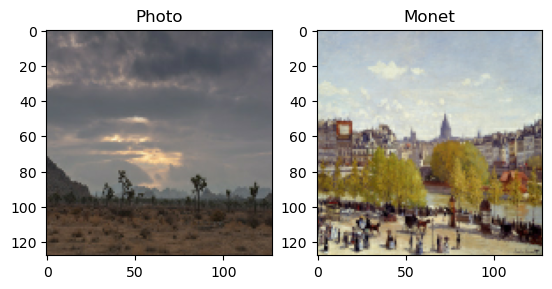

In [6]:
# Visualize an example of the dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow((example_photo[0] * 0.5 + 0.5).numpy())

plt.subplot(122)
plt.title('Monet')
plt.imshow((example_monet[0] * 0.5 + 0.5).numpy())
plt.show()

## Model Components: Downsample and Upsample Blocks

The CycleGAN architecture relies on key building blocks for transforming and generating images:

- Downsample Block: A convolutional block that reduces spatial dimensions using a stride of 2. It optionally applies instance normalization, followed by a Leaky ReLU activation. This block is used in the encoder section of the generator and the discriminator to capture hierarchical features effectively.

- Upsample Block: A transposed convolutional block that increases spatial dimensions. It applies instance normalization and optionally adds dropout for regularization, followed by a ReLU activation. This block is used in the decoder section of the generator to reconstruct higher-resolution outputs.

These modular blocks enable flexibility and efficient feature extraction and reconstruction.

In [7]:
# Define the downsample block
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.LayerNormalization(axis=-1))

    result.add(layers.LeakyReLU())

    return result

In [8]:
# Define the upsample block
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.LayerNormalization(axis=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Model Architecture: Generator and Discriminator

The CycleGAN model consists of two key components for each domain transformation: the Generator and the Discriminator.

### Generator
The generator is a U-Net-inspired architecture with an encoder-decoder structure. It transforms input images into the target domain:
- Encoder (Downsampling): Extracts hierarchical features using the downsample blocks, progressively reducing spatial dimensions.
- Decoder (Upsampling): Reconstructs the target image using the upsample blocks, with skip connections to preserve fine details from the encoder.
- Output Layer: A transposed convolution layer with a tanh activation produces the final transformed image with 3 output channels (RGB).

Skip connections between the encoder and decoder layers help retain spatial information, which is critical for high-quality image generation.

### Discriminator
The discriminator is a patch-based classifier that determines whether an image is real or generated:
- Downsampling Layers: Multiple downsample blocks extract features and reduce spatial dimensions.
- Convolutional Layers: Final layers apply zero-padding and convolution to predict the authenticity of image patches.
- Output Layer: Produces a single output for each patch, indicating whether it belongs to the real or generated image class.

This patch-based approach ensures the discriminator evaluates local texture details, improving the quality of the generated images.


In [9]:
# Define the Generator
OUTPUT_CHANNELS = 3

def Generator():
    inputs = layers.Input(shape=[128, 128, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        
        
        downsample(512, 4),
    ]

    up_stack = [
        
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [10]:
# Define the Discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[128, 128, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = layers.LayerNormalization(axis=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)


## Model Initialization and Loss Functions

### Instantiating Generators and Discriminators
Using TensorFlow's distribution strategy, we instantiate the model components:
- Monet Generator: Transforms photographs into Monet-style paintings.
- Photo Generator: Transforms Monet paintings into realistic photos.
- Monet Discriminator: Differentiates between real Monet paintings and generated ones.
- Photo Discriminator: Differentiates between real photos and generated ones.

These components form the foundation of the CycleGAN, enabling bidirectional style transformation.

### Loss Functions
The CycleGAN training process relies on several loss functions to guide the generators and discriminators. These losses are combined to strike a balance between generating realistic images and maintaining consistency across transformations.


In [11]:
# Instantiate the Generators and Discriminators with strategy scope
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [12]:
# Define the loss functions
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        if loss is None:
            loss = tf.constant(0.0, dtype=tf.float32)
        return LAMBDA * 0.5 * loss

## CycleGAN Model Compilation

### Custom CycleGAN Class
The CycleGAN model is implemented as a custom subclass of tf.keras.Model.


The train_step method defines a single training step:
1. Forward Pass: Transforms input images using the generators and calculates reconstructed images.
2. Discriminator Evaluation: Computes the discriminator outputs for real and generated images.
3. Loss Calculation: Evaluates generator, discriminator, cycle consistency, and identity losses.
4. Gradient Updates: Calculates and applies gradients for all model components.

### Loss Balancing with Lambda Cycle
The parameter lambda_cycle is used to balance the importance of the cycle consistency loss relative to other loss terms. This ensures the generators focus on both realism and domain consistency.

The class design allows for modular training and easy integration of new optimizers or loss functions.

In [13]:
# Compile the CycleGAN model
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Training the CycleGAN Model

### Training Process
The CycleGAN model is trained using the following configuration:
- Mixed Precision: Enabled via TensorFlow's mixed_float16 policy to speed up training and reduce memory usage on GPUs.
- Optimizers: Adam optimizers are used for both generators and discriminators, with a learning rate of 2e-4 and a decay schedule for gradual learning rate reduction.
- Batching: Training is conducted on batches of paired datasets (Monet paintings and photos) for 25 epochs, with 300 steps per epoch.

The model learns to translate between the two domains (photos ↔ Monet paintings) while preserving content consistency and style fidelity.

In [ ]:
# Train the CycleGAN model

# Enable mixed precision to speed up training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=2e-4,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
        )
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    steps_per_epoch=300
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 3000, compute capability 7.5
Epoch 1/25
300/300 [==============================] - 853s 3s/step - monet_gen_loss: 5.4210 - photo_gen_loss: 5.5340 - monet_disc_loss: 0.7210 - photo_disc_loss: 0.7332
Epoch 2/25
300/300 [==============================] - 1066s 4s/step - monet_gen_loss: 3.7872 - photo_gen_loss: 3.7365 - monet_disc_loss: 0.6387 - photo_disc_loss: 0.6575
Epoch 3/25
300/300 [==============================] - 783s 3s/step - monet_gen_loss: 3.2810 - photo_gen_loss: 3.2366 - monet_disc_loss: 0.6338 - photo_disc_loss: 0.6474
Epoch 4/25
300/300 [==============================] - 566s 2s/step - monet_gen_loss: 3.0127 - photo_gen_loss: 2.9900 - monet_disc_loss: 0.6272 - photo_disc_loss: 0.6326
Epoch 5/25
300/300 [==============================] - 853s 3s/step - monet_gen_loss: 2.821

### Visualizing Results
The output of the trained model is visualized by displaying a real photo from the dataset together with the corresponding Monet-style painting created by the generator.

Below is a sample visualization showcasing side-by-side comparisons of input photos and their Monet-inspired transformations.

This step allows for qualitative evaluation of the generated images, helping assess the model's ability to produce realistic and artistic results.

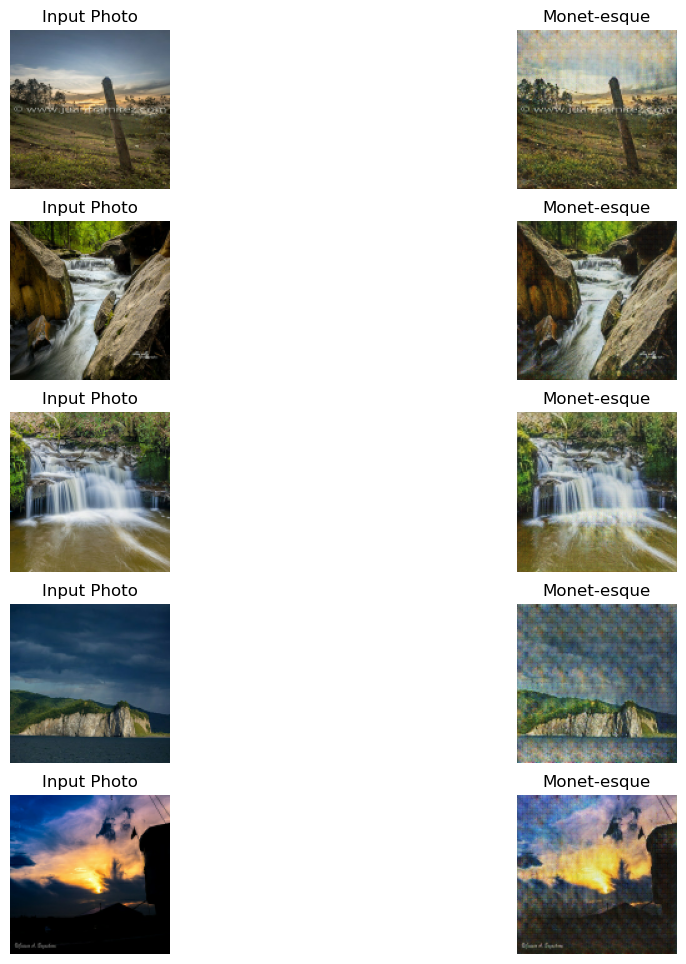

In [ ]:
# Visualize the results
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Generating and Packaging the Submission

### Image Generation
The trained Monet generator is used to transform 300 photos into Monet-style paintings. These generated images are saved as .jpg files in an output directory.
The contents of the submission.zip file are verified by printing the list of included files. This ensures that the archive meets the expected format for Kaggle submission.

In [ ]:
import os
from PIL import Image
import zipfile
import shutil

output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

i = 1
for img in photo_ds.take(300):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i}.jpg"))
    i += 1

shutil.make_archive("submission", 'zip', output_dir)

with zipfile.ZipFile("submission.zip", 'r') as zip_ref:
    print("Files in submission.zip:")
    print(zip_ref.namelist())

Files in submission.zip:
['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '17.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175.jpg', '176.jpg', '177.jpg', '178.jpg', '179.jpg', '18.j